In [21]:
# Import all libraries

import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Interesting Atoms as input

filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-55k-65k.npy"
data = np.load(filePath)
data.shape

(10000, 6126, 3)

In [23]:
# View Data Shape
# data = data[:200000]
# data = np.array(data)
# data.shape

In [24]:
# Transpose the data for Convoy algorithm

transposed_data = list()
for x in range(len(data[1])):
    
    transposed_data.append(data[:,x,0:3].tolist())

convoy_data = transposed_data
#convoy_data

In [25]:
# cluster = DBSCAN(eps=9, min_samples=4).fit(data[0])

# print("Number of Clusters = ", max(cluster.labels_)+1)

In [26]:
class ConvoyCandidate(object):
    """
    Attributes:
        indices(set): The object indices assigned to the convoy
        is_assigned (bool):
        start_time (int):  The start index of the convoy
        end_time (int):  The last index of the convoy
    """
    __slots__ = ('indices', 'is_assigned', 'start_time', 'end_time')

    def __init__(self, indices, is_assigned, start_time, end_time):
        self.indices = indices
        self.is_assigned = is_assigned
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return '<%r %r indices=%r, is_assigned=%r, start_time=%r, end_time=%r>' % (self.__class__.__name__, id(self), self.indices, self.is_assigned, self.start_time, self.end_time)

In [27]:
class CMC(object):
    """Coherence Moving Cluster (CMC) algorithm

    Attributes:
        k (int):  Min number of consecutive timestamps to be considered a convoy
        m (int):  Min number of elements to be considered a convoy
    """
    def __init__(self, clf, k, m):
        self.clf = clf
        self.k = k
        self.m = m

    def fit_predict(self, X, y=None, sample_weight=None):
        convoy_candidates = set()
        columns = len(X[0])
        column_iterator = range(columns)
        output_convoys = []

        for column in column_iterator:
            current_convoy_candidates = set()
            values = [row[column] if isinstance(row[column], (list, set)) else [row[column]] for row in X]
            if len(values) < self.m:
                continue
            clusters = self.clf.fit_predict(values, y=y, sample_weight=sample_weight)
            unique_clusters = set(clusters)
            clusters_indices = dict((cluster, ConvoyCandidate(indices=set(), is_assigned=False, start_time=None, end_time=None)) for cluster in unique_clusters)

            for index, cluster_assignment in enumerate(clusters):
                clusters_indices[cluster_assignment].indices.add(index)

            # update existing convoys
            for convoy_candidate in convoy_candidates:
                convoy_candidate_indices = convoy_candidate.indices
                convoy_candidate.is_assigned = False
                for cluster in unique_clusters:
                    cluster_indices = clusters_indices[cluster].indices
                    cluster_candidate_intersection = cluster_indices & convoy_candidate_indices
                    if len(cluster_candidate_intersection) < self.m:
                        continue
                    convoy_candidate.indices = cluster_candidate_intersection
                    current_convoy_candidates.add(convoy_candidate)
                    convoy_candidate.end_time = column
                    clusters_indices[cluster].is_assigned = convoy_candidate.is_assigned = True

                # check if candidates qualify as convoys
                candidate_life_time = (convoy_candidate.end_time - convoy_candidate.start_time) + 1
                if (not convoy_candidate.is_assigned or column == column_iterator[-1]) and candidate_life_time >= self.k:
                    output_convoys.append(convoy_candidate)

            # create new candidates
            for cluster in unique_clusters:
                cluster_data = clusters_indices[cluster]
                if cluster_data.is_assigned:
                    continue
                cluster_data.start_time = cluster_data.end_time = column
                current_convoy_candidates.add(cluster_data)
            convoy_candidates = current_convoy_candidates
        return output_convoys

In [28]:
# Clustering using DBSCAN
clustering_clf = DBSCAN(eps=2.13)


In [29]:
# # Test data of 3D Coordinates
# # Elements (Molecules) are in row, timesteps are in column

# test_data = ([[3,1,3],[3,2,4],[2,4,5]],
#         [[4,2,2],[6,2,3],[4,4,5]],
#         [[1,1,3],[51,2,-1],[55,3,0]],
#         [[51,2,1],[52,2,4],[56,-3, 2]])

In [ ]:
# Min elements for convoy = m
# Min consecutive timesteps = k

clf = CMC(clustering_clf, k=50, m=30)

# Convoy calculation using Test data
convoys = clf.fit_predict(convoy_data)
print("Total number of Convoys =", len(convoys))

In [12]:
# # file = open("output.txt", "w")

# for convoy in convoys:
#     print('No of elements in the Convoy',len(convoy.indices))  
# #     for i in convoy.indices:
# #         print('%i: %r - Start Time: %r, End Time: %r' % (i, data[i], convoy.start_time, convoy.end_time))
#     print(convoy)
# #     file.write('%r - S: %r, E: %r\n' % (convoy.indices, convoy.start_time, convoy.end_time))
# #     file.write(str(convoy.start_time))
# #     file.write(str(convoy.end_time))
# # file.close()

In [13]:
# df = pd.read_csv(r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\atom_list.csv")

# for convoy in convoys:
#     print('No of elements in this Convoy = ',len(convoy.indices))
#     print(convoy)
# #     print (sorted(convoy.indices))
#     convoy_atom_type = list()
#     for x in convoy.indices:
#         convoy_atom_type.append(df.iloc[x].atom_type)
        
#     print(convoy_atom_type)


In [ ]:
drugName = "SFL11"

#load HB info and extract the information for 3 interesting atoms - this will help filter out the convoys in the next cell

dfHB = pd.read_csv(r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\longestHBatomid.csv")
drugInfo = dfHB[dfHB["drug"] == drugName]
threeAtoms = ["nitrogen_atom_id", "hydrogen_atom_id", "oxygen_atom_id"]
x = drugInfo[threeAtoms].values

In [ ]:
outputFilename = "convoys_test.txt"
count = 0
for convoy in convoys:
    if x.issubset(convoy.indices):
        indices = list(convoy.indices)
        indices.sort()
        count = count+1
        print(count)
        print(indices)
        
            
# with open(outputFilename, 'w') as f:
#         for convoy in convoys:
#             for x in drugInfo[threeAtoms].values:
#                 # print(x)
#                 for i in x:
#                     # print(i)
#                     if i in convoy.indices:
#                         indices = list(convoy.indices)
#                         indices.sort()
#                         print(f"Convoy has {len(convoy.indices)} elements starting at {convoy.start_time} and ending at {convoy.end_time}")
#                         print(indices)
#                         continue

# f.close()
# print(f"Written to {outputFilename}")

In [15]:
# outputFilename = "convoys.txt"

# from contextlib import redirect_stdout
# with open(outputFilename, 'w') as f:
#     with redirect_stdout(f):
#         for convoy in convoys:
#             for x in drugInfo[threeAtoms].values:
#                 # print(x)
#                 for i in x:
#                     # print(i)
#                     if i in convoy.indices:
#                         # print('No of elements in this Convoy = ',len(convoy.indices))
#                         # print("atom id", i)
#                         indices = list(convoy.indices)
#                         indices.sort()
#                         print(f"Convoy has {len(convoy.indices)} elements starting at {convoy.start_time} and ending at {convoy.end_time}")
#                         print(indices)
#         #     print (sorted(convoy.indices))
#                         # convoy_atom_type = list()
#                         # for y in convoy.indices:
#                         #     convoy_atom_type.append(df.iloc[y].atom_type)

#                         # print(convoy_atom_type)
#                         continue

# f.close()
# print(f"Written to {outputFilename}")



Written to convoys.txt


In [16]:
# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Abdullah Data\ring_centers.npy"
# data = np.load(filePath)
# data = data[:200000]
# data = np.array(data)
# data.shape


In [19]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data[1500])
distances, indices = nbrs.kneighbors(data[1500])

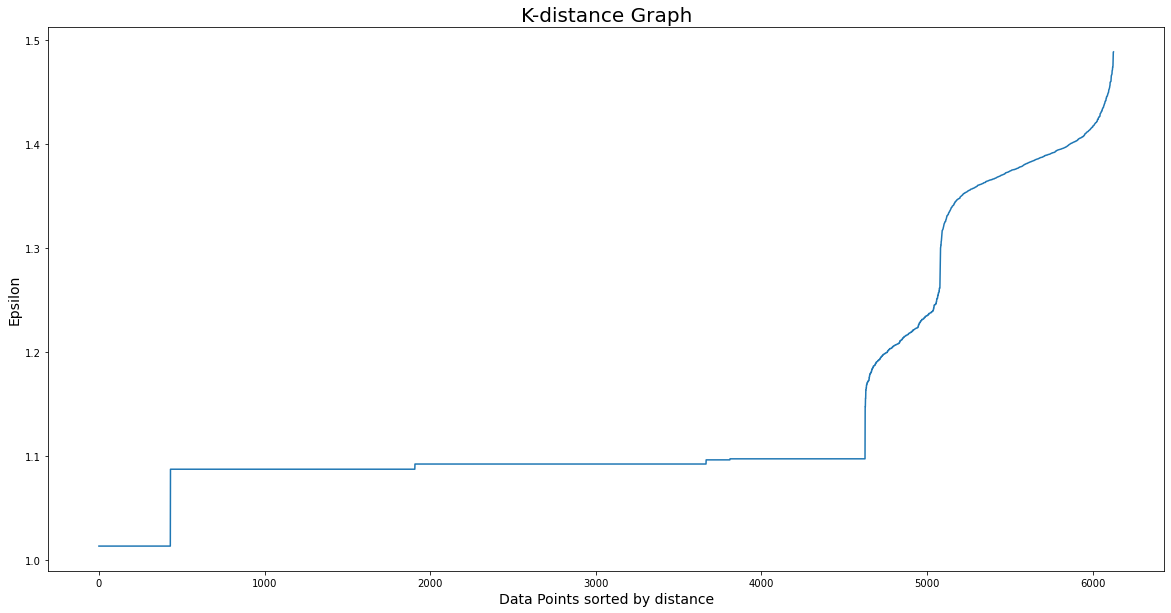

In [20]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()